# Import necessary libraries

In [1]:
!python -m pip install pandas numpy matplotlib seaborn scipy kneed scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import seaborn.objects as so

In [4]:
from scipy import stats
from scipy import interpolate

# Parse the data

In [5]:
STUDY = 'Study_Hours_Per_Day'
CLUBS = 'Extracurricular_Hours_Per_Day'
SLEEP = 'Sleep_Hours_Per_Day'
SOCIAL = 'Social_Hours_Per_Day'
PHYSICAL = 'Physical_Activity_Hours_Per_Day'
STRESS = 'Stress_Level'
GENDER = 'Gender'
GRADES = 'Grades'
STRESS_GROUPED = 'Stress_Grouped'

def humanize_column(column):
    output = ''
    for word in column.split('_'):
        output += (word + ' ')
    return output.rstrip()

def abbreviate_column(column):
    if column == STRESS_GROUPED:
        return 'Stress Grouped'
    else:
        words = column.split('_')
        if len(words) == 1:
            return words[0]
        else:
            return words[0] + ' ' + words[1]

In [6]:
# Parse Dataframe
df = pd.read_csv(
    "student_lifestyles.csv", index_col=0
)
df = df.astype(dtype={'Stress_Level': 'category', 'Gender': 'category'})
df[STRESS_GROUPED] = df[STRESS].map({
    "Low": "Low/Moderate",
    "Moderate": "Low/Moderate",
    "High": "High"
}).astype("category")
print(df.dtypes)

Study_Hours_Per_Day                 float64
Extracurricular_Hours_Per_Day       float64
Sleep_Hours_Per_Day                 float64
Social_Hours_Per_Day                float64
Physical_Activity_Hours_Per_Day     float64
Stress_Level                       category
Gender                             category
Grades                              float64
Stress_Grouped                     category
dtype: object


In [7]:
num_df = df.drop([GENDER, STRESS, STRESS_GROUPED], axis=1)

# Explore Correlated data

In [8]:
corr = num_df.corr(method='spearman')

<Axes: >

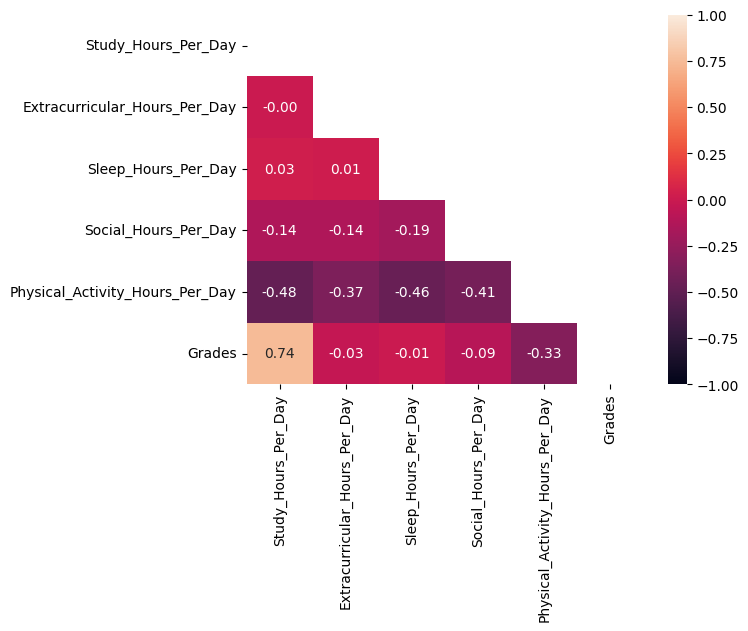

In [9]:
sns.heatmap(
    corr,
    cmap='rocket',
    annot=True,
    mask=np.triu(np.ones_like(corr, dtype=bool)),
    fmt=".2f",
    vmin=-1, vmax=1,
)

# The High Stress Heatmap is an outlier

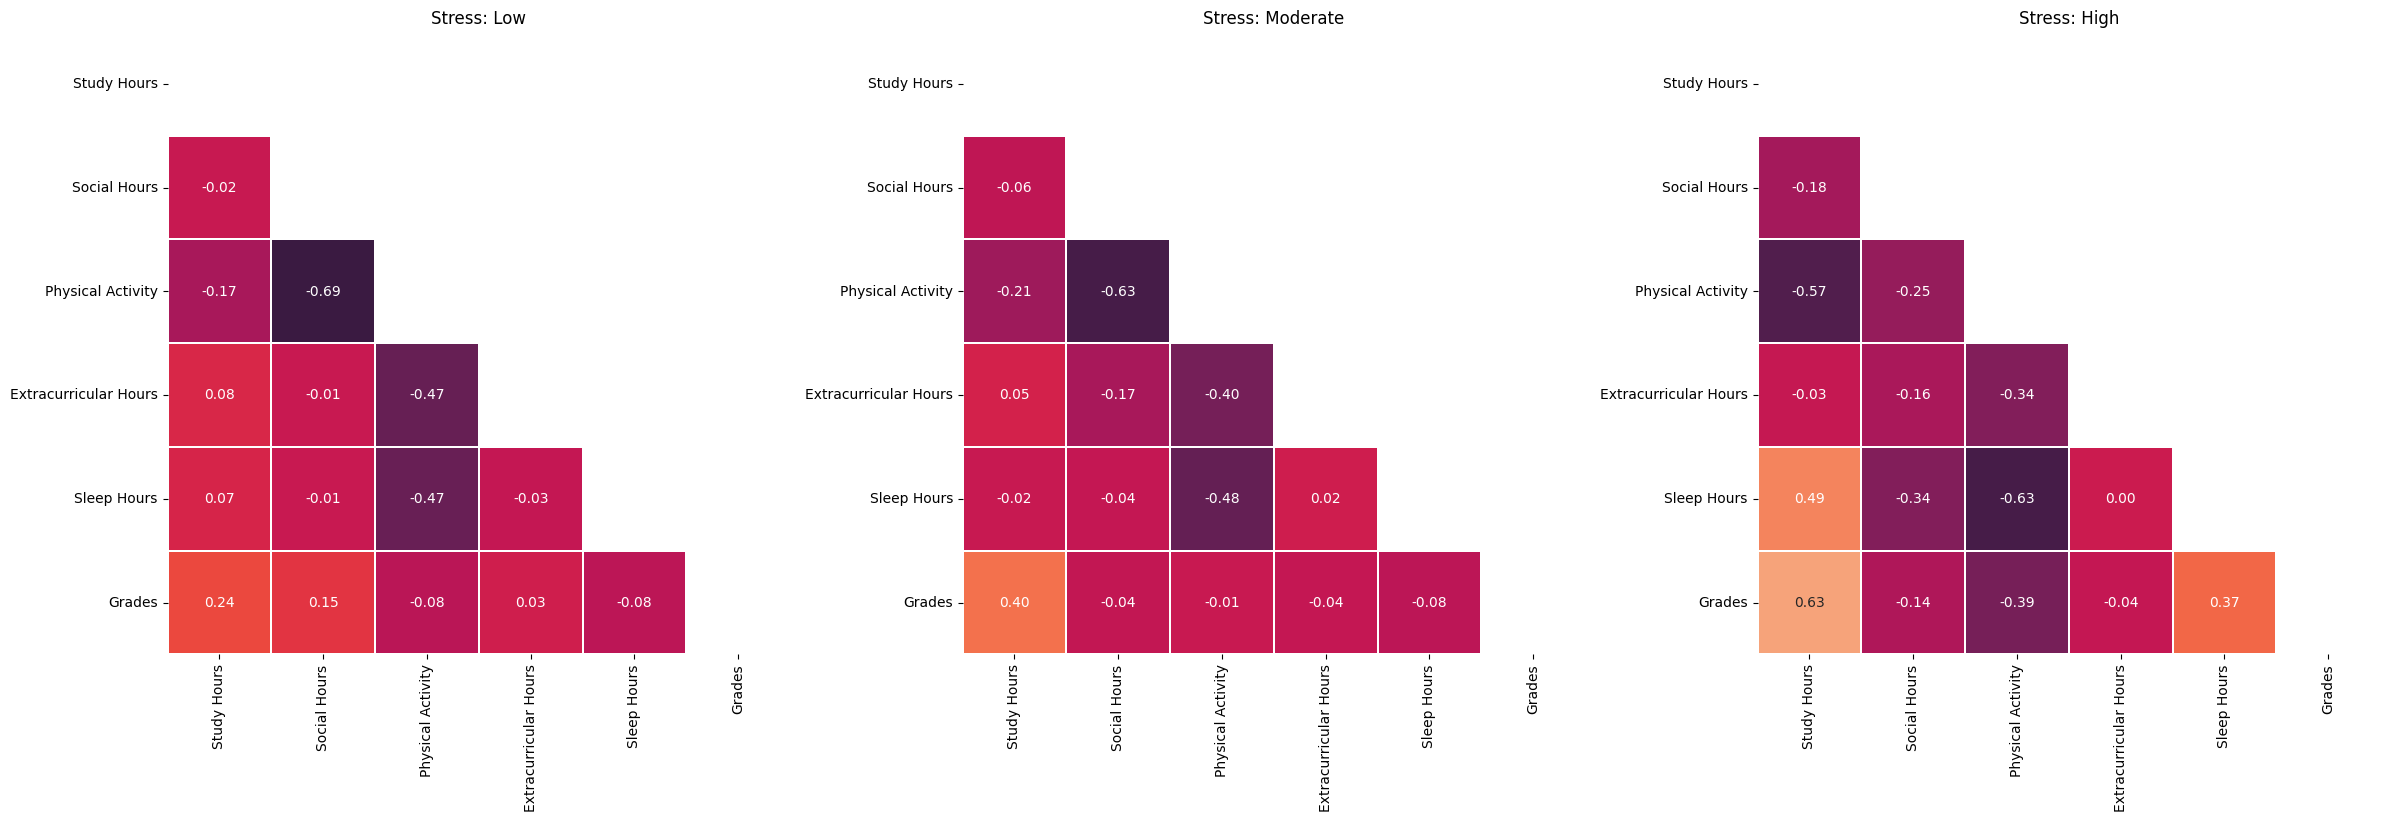

In [16]:
variables = [STUDY, SOCIAL, PHYSICAL, CLUBS, SLEEP, GRADES]
abberviated_vars = [abbreviate_column(col) for col in variables]
stress_levels = ['Low', 'Moderate', 'High']
n = len(stress_levels)

fig, axes = plt.subplots(1, n, figsize=(8 * n, 8), squeeze=False)

for i, stress_level in enumerate(stress_levels):
    ax = axes[0, i]
    group = df[df[STRESS] == stress_level]
    corr = group[variables].corr(method='spearman')

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="rocket",
        vmin=-1, vmax=1,
        center=0,
        mask=mask,
        linewidths=0.25,
        square=True,
        cbar=False,           # show colorbar on every heatmap
        ax=ax,
        xticklabels=abberviated_vars,
        yticklabels=abberviated_vars
    )
    ax.set_title(f"{stress_level}")
    ax.set_aspect('equal', adjustable='box')  # keep aspect ratio equal

plt.tight_layout()
plt.show()

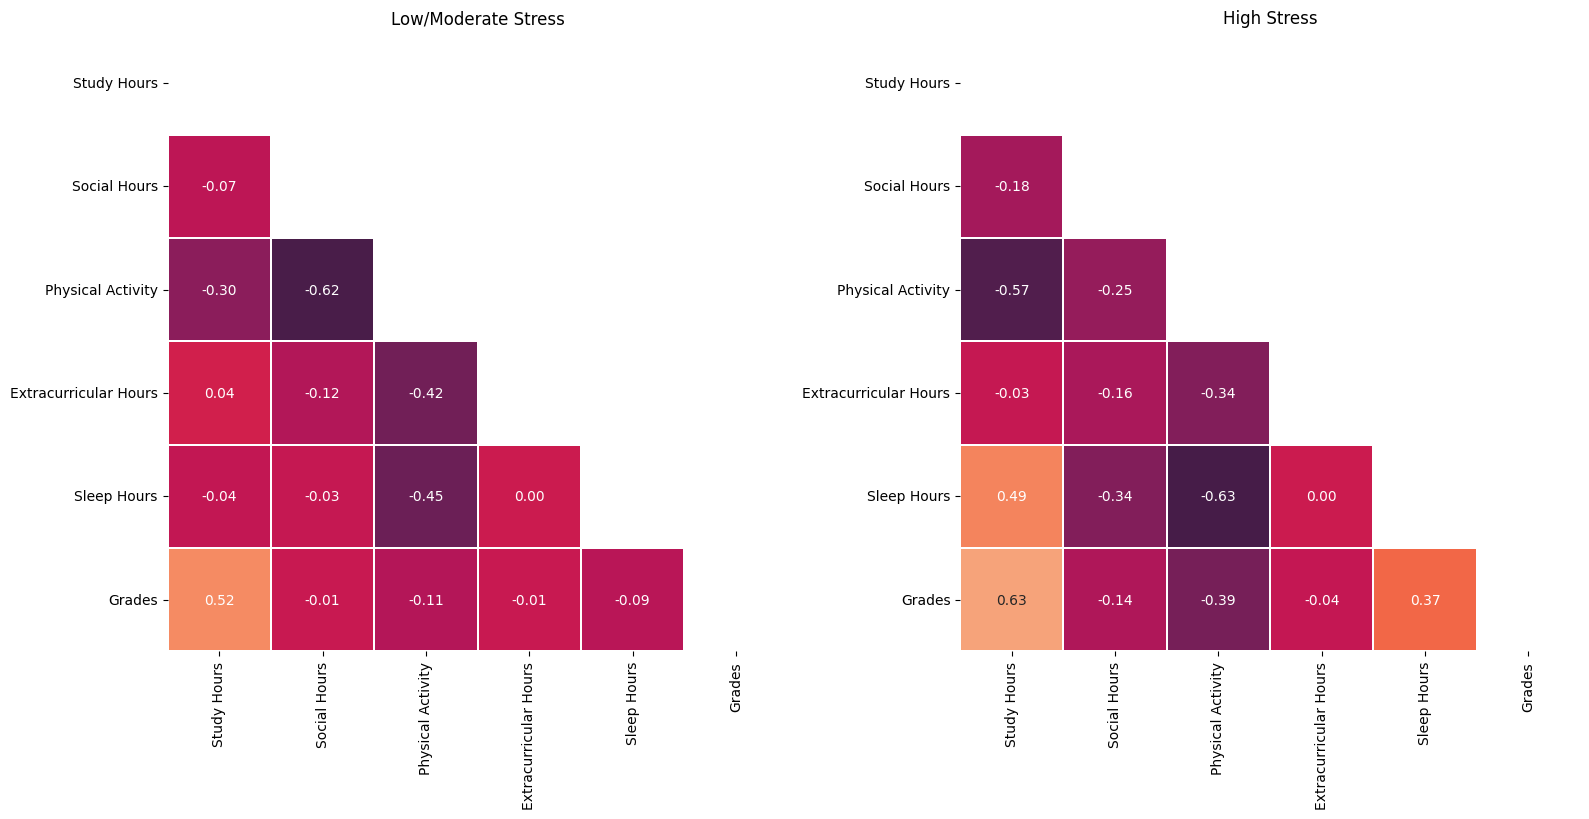

In [18]:
variables = [STUDY, SOCIAL, PHYSICAL, CLUBS, SLEEP, GRADES]
abberviated_vars = [abbreviate_column(col) for col in variables]
stress_levels = ['Low/Moderate', 'High']
n = len(stress_levels)

fig, axes = plt.subplots(1, n, figsize=(8 * n, 8), squeeze=False)

for i, stress_level in enumerate(stress_levels):
    ax = axes[0, i]
    group = df[df[STRESS_GROUPED] == stress_level]
    corr = group[variables].corr(method='spearman')

    mask = np.triu(np.ones_like(corr, dtype=bool))

    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap="rocket",
        vmin=-1, vmax=1,
        center=0,
        mask=mask,
        linewidths=0.25,
        square=True,
        cbar=False,           # show colorbar on every heatmap
        ax=ax,
        xticklabels=abberviated_vars,
        yticklabels=abberviated_vars
    )
    ax.set_title(f"{stress_level} Stress")
    ax.set_aspect('equal', adjustable='box')  # keep aspect ratio equal

plt.tight_layout()
plt.show()

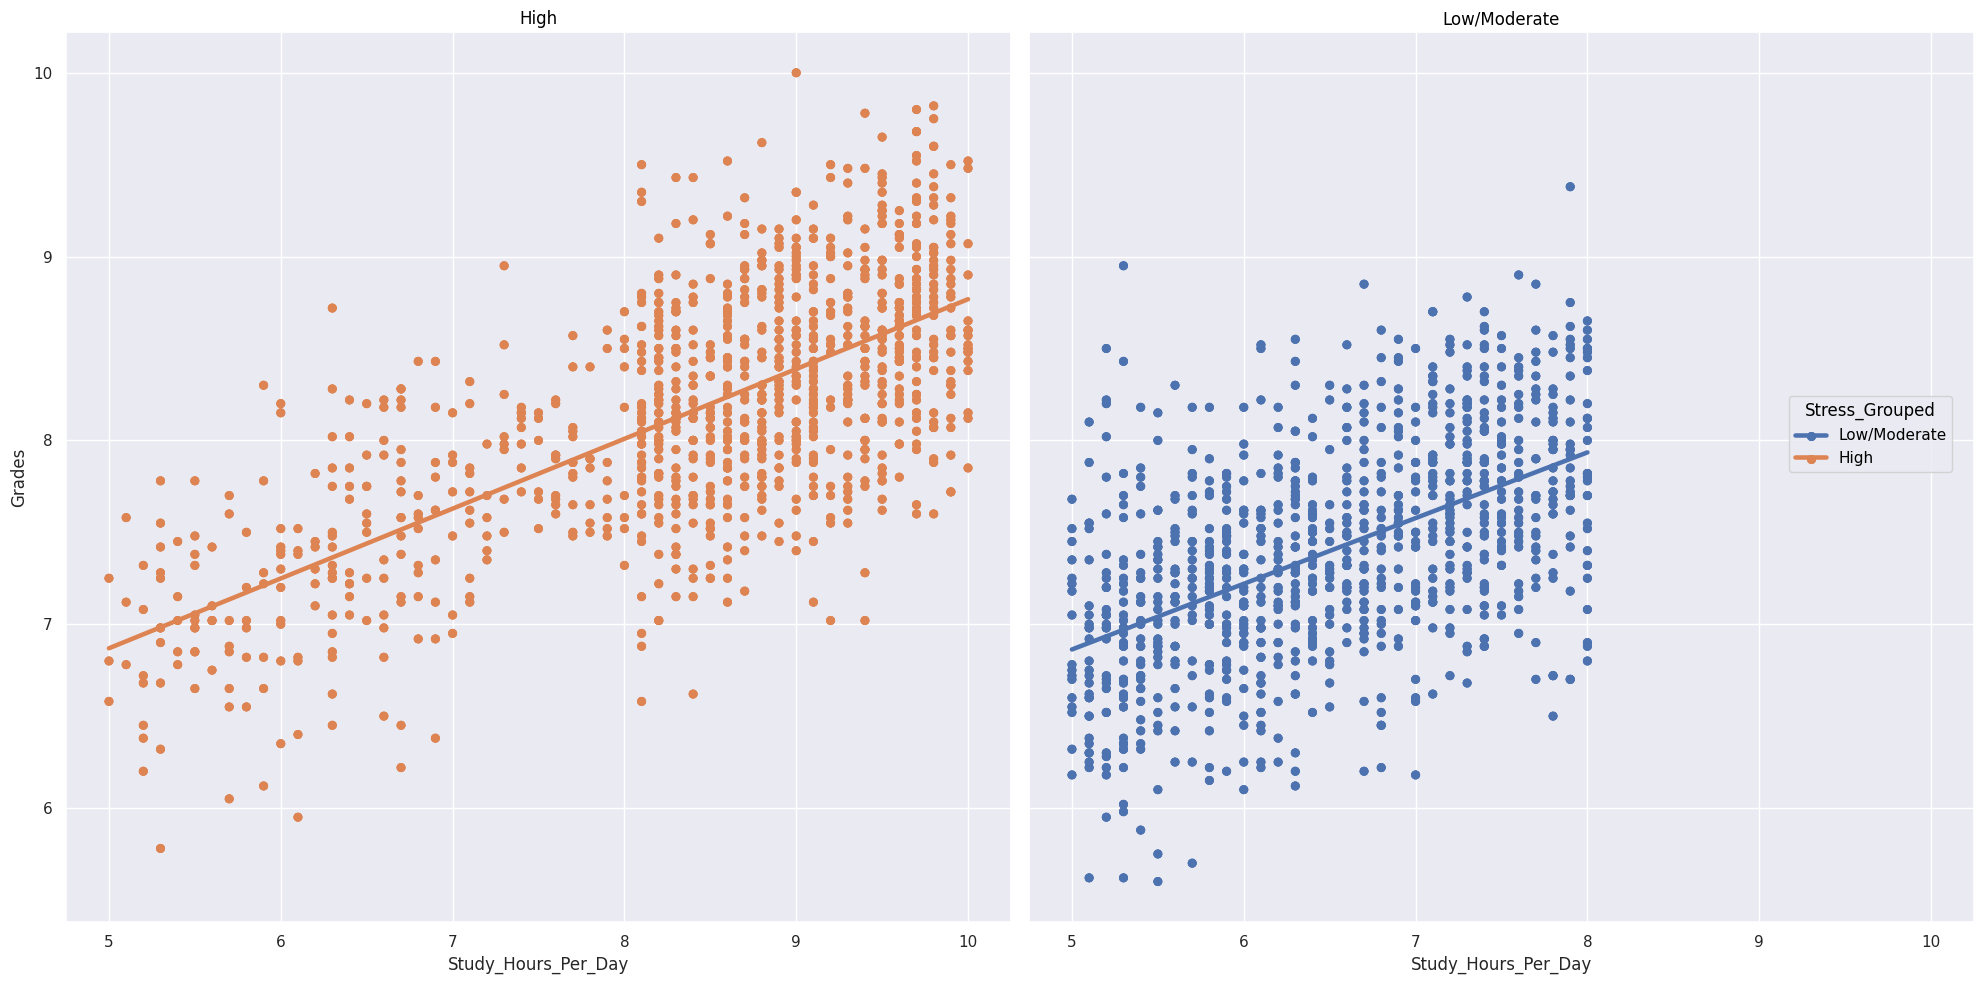

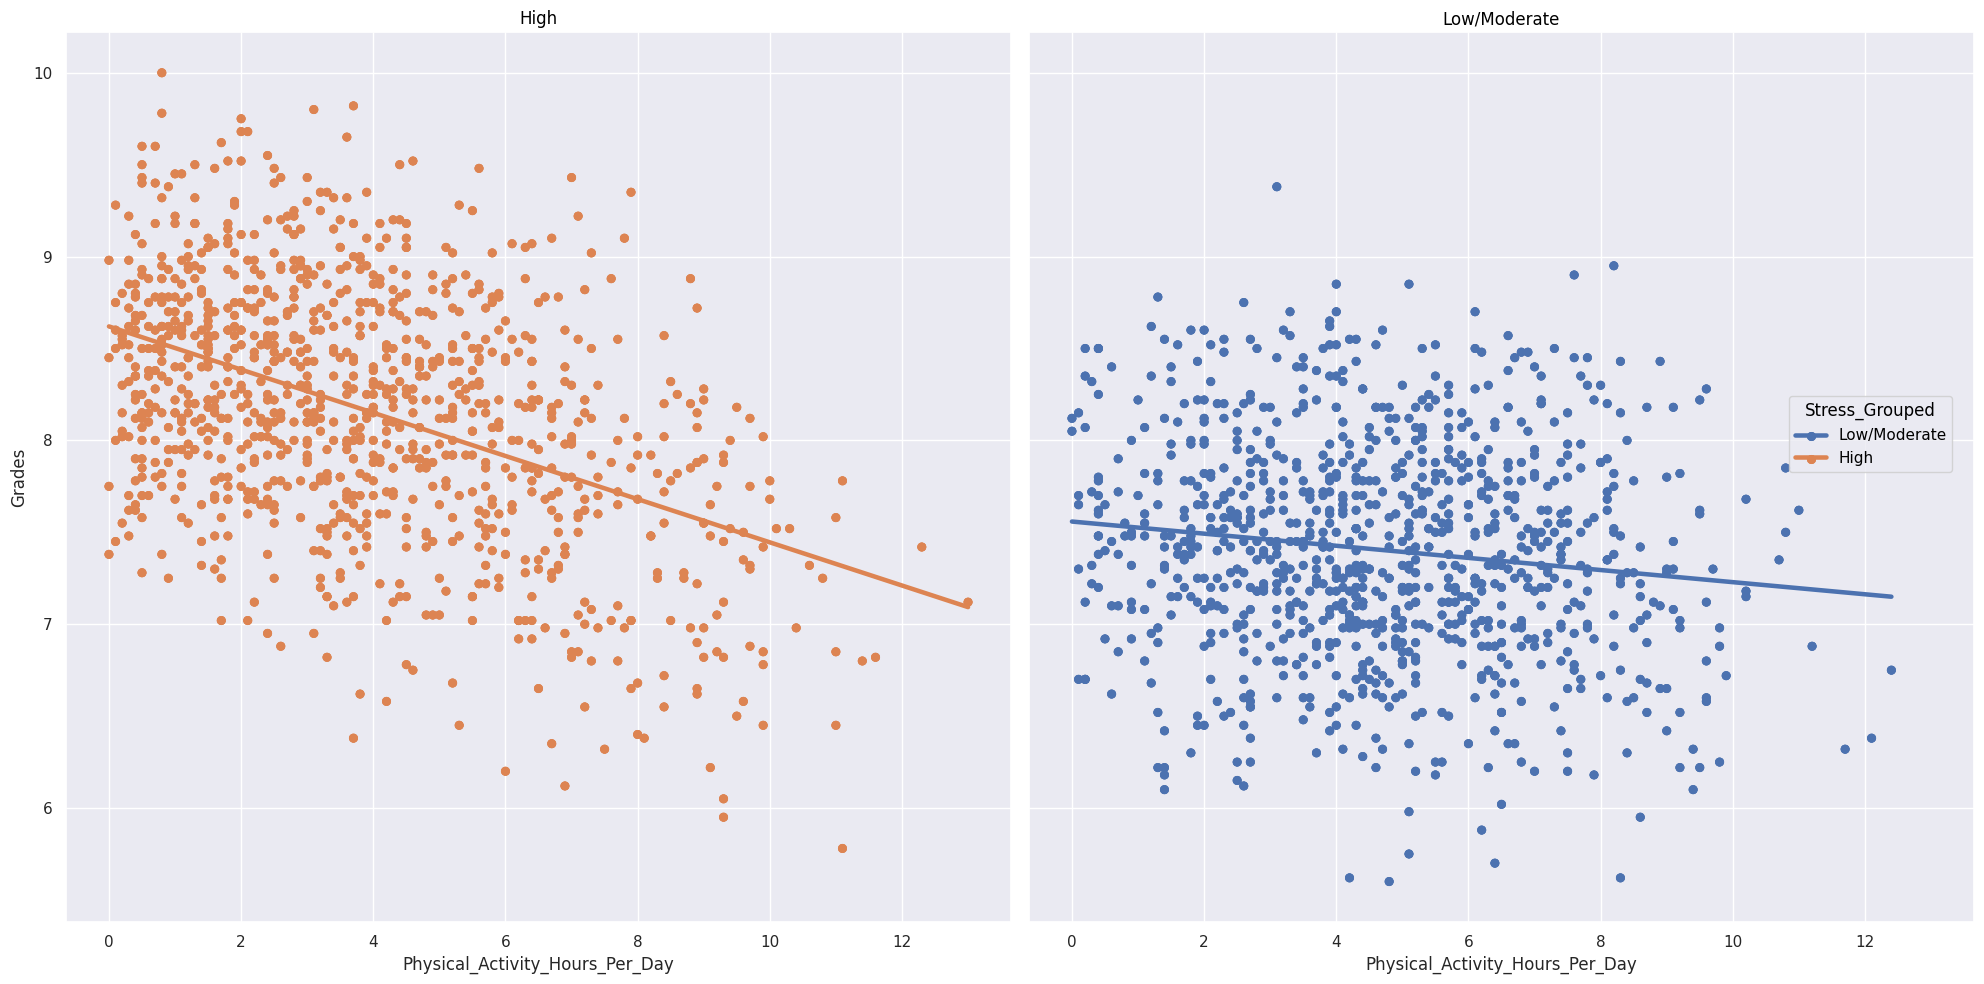

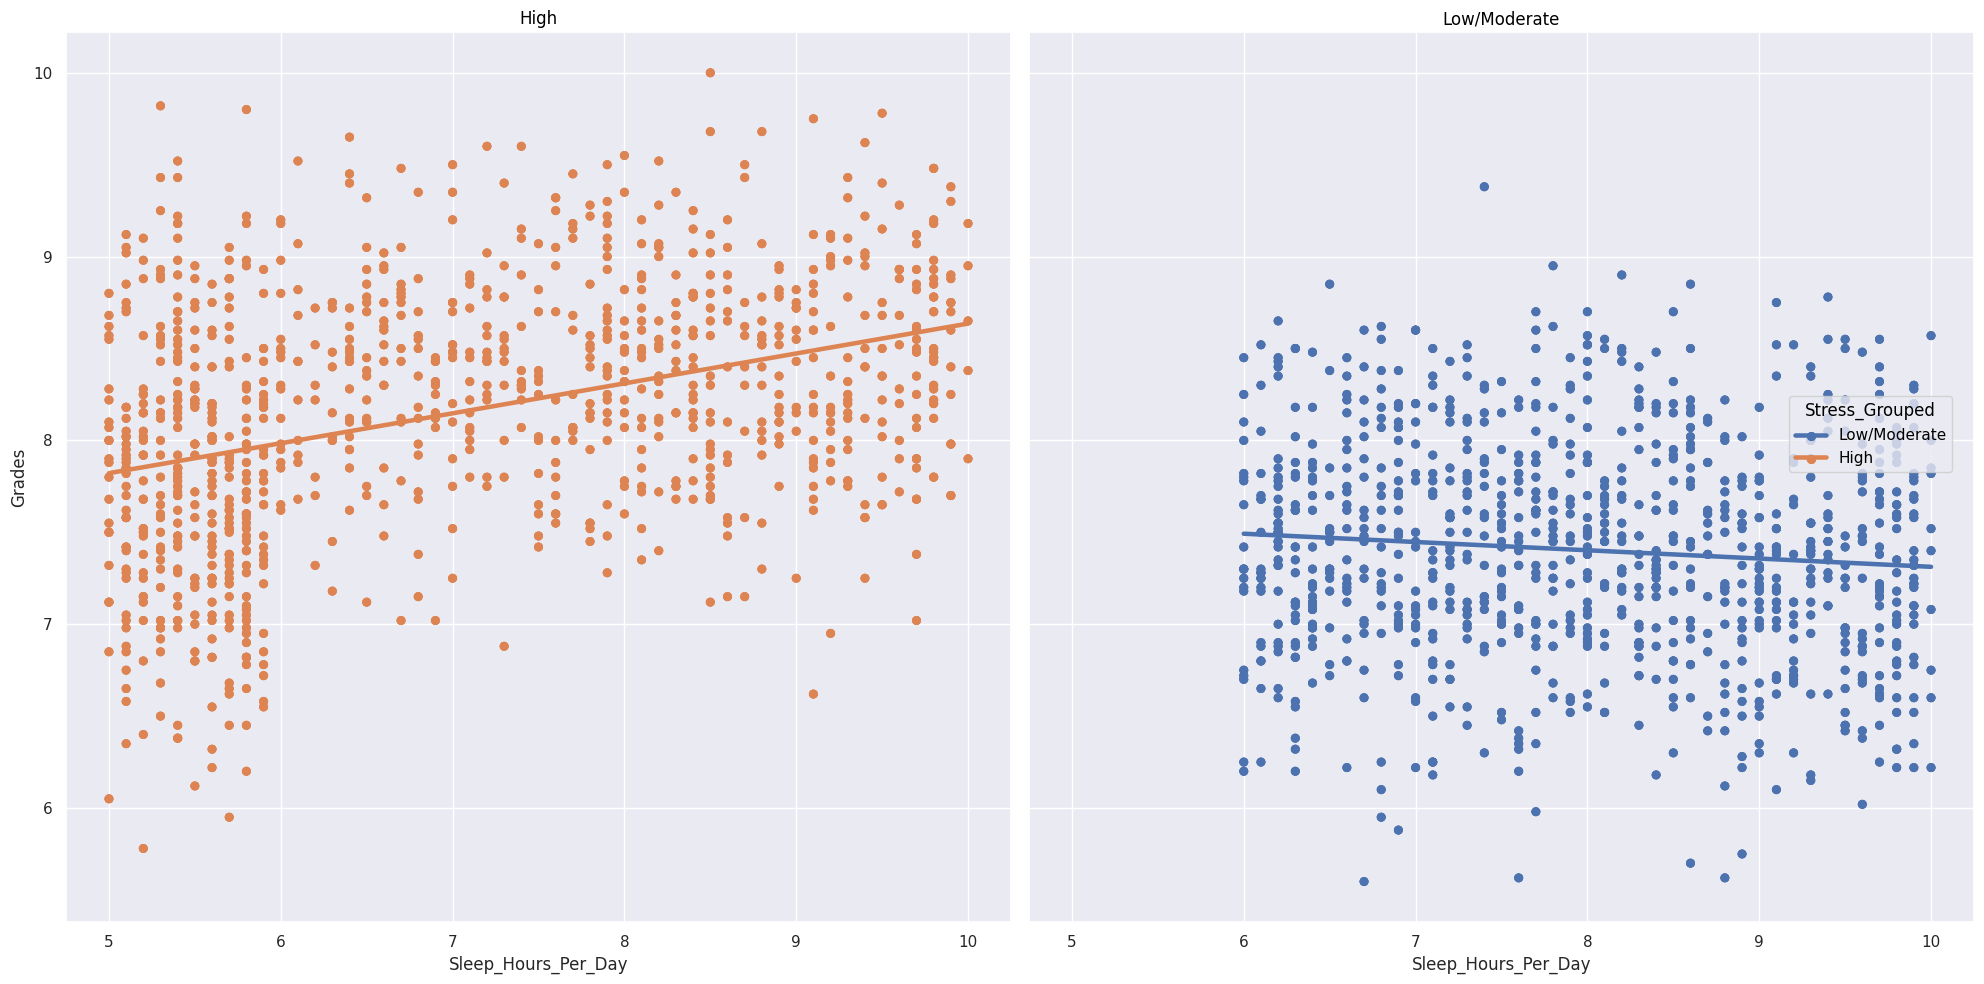

In [12]:
for x_axis, y_axis in [(STUDY, GRADES), (PHYSICAL, GRADES), (SLEEP, GRADES)]:
  (
    so.Plot(data=df, x=x_axis, y=GRADES, color=STRESS_GROUPED)
    .add(so.Dot())
    .add(so.Line(linewidth=3.25), so.PolyFit(order=1))
    .facet(col=STRESS_GROUPED)
    .layout(size=(20,10))
    .add(so.Dot())
    .show()
  )

# How sleep and study hours both influence grade in high stress students
* The heatmap has a large chunk of missing data

/tmp/ipykernel_2846/2309533998.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high['study_bin'] = pd.cut(high[STUDY], bins=bins)
/tmp/ipykernel_2846/2309533998.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high['sleep_bin'] = pd.cut(high[SLEEP], bins=bins)
/tmp/ipykernel_2846/2309533998.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future defa

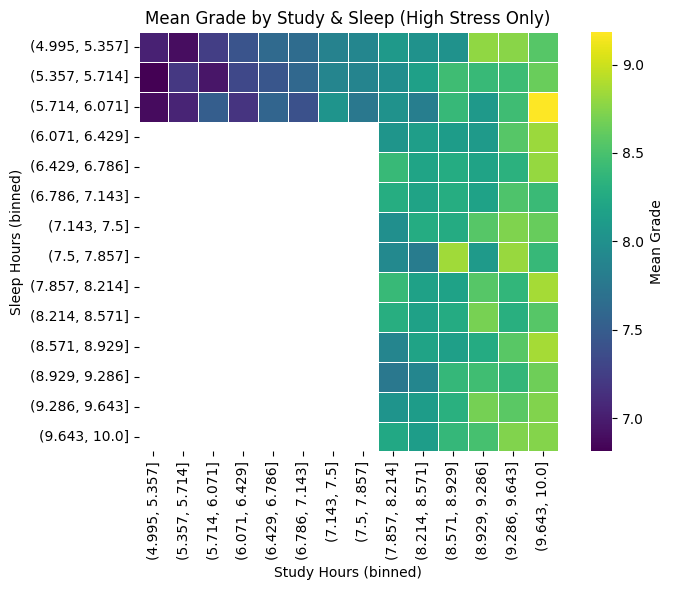

In [13]:
# 1. Filter to High-stress students
high = df[df[STRESS] == 'High']

# 2. Bin study and sleep into discrete intervals
bins = 14  # adjust for finer resolution
high['study_bin'] = pd.cut(high[STUDY], bins=bins)
high['sleep_bin'] = pd.cut(high[SLEEP], bins=bins)

# 3. Aggregate mean grades for each bin pair
grid = (
    high
    .groupby(['study_bin', 'sleep_bin'])
    .agg(mean_grade=(GRADES, 'mean'))
    .reset_index()
)

# 4. Pivot into a matrix
heat_data = grid.pivot(
    index='sleep_bin',
    columns='study_bin',
    values='mean_grade'
)

grid = (
    high
    .groupby(['study_bin', 'sleep_bin'])
    .agg(mean_grade=(GRADES, 'mean'))
    .reset_index()
)

# Using pivot_table with fill_value to avoid missing cells
heat_data = grid.pivot_table(
    index='sleep_bin',
    columns='study_bin',
    values='mean_grade',
    fill_value=np.nan  # or 0, depending on preference
)

# 5. Plot with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    heat_data,
    fmt=".1f",
    cmap="viridis",
    cbar_kws={'label': 'Mean Grade'},
    linewidths=0.5,
    square=True
)
plt.xlabel("Study Hours (binned)")
plt.ylabel("Sleep Hours (binned)")
plt.title("Mean Grade by Study & Sleep (High Stress Only)")
plt.tight_layout()
plt.show()

# Differences in variables between stress levels

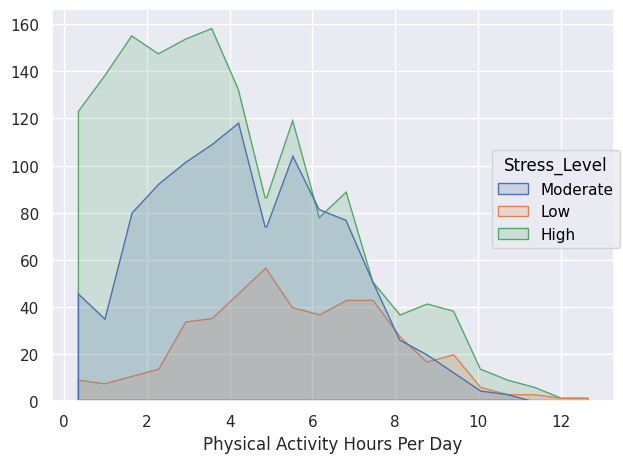

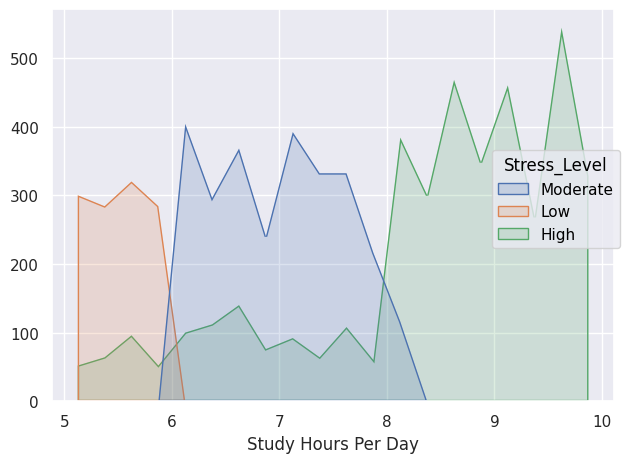

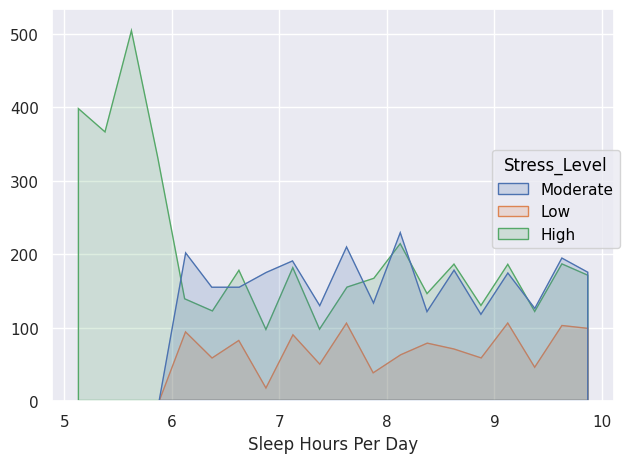

In [14]:
for variable in [PHYSICAL, STUDY, SLEEP]:
    (
        so.Plot(data=df, x=variable, color=STRESS)
        .add(so.Area(), so.Hist(stat="frequency", bins=20))
        .label(x=humanize_column(variable))
        .show()
    )

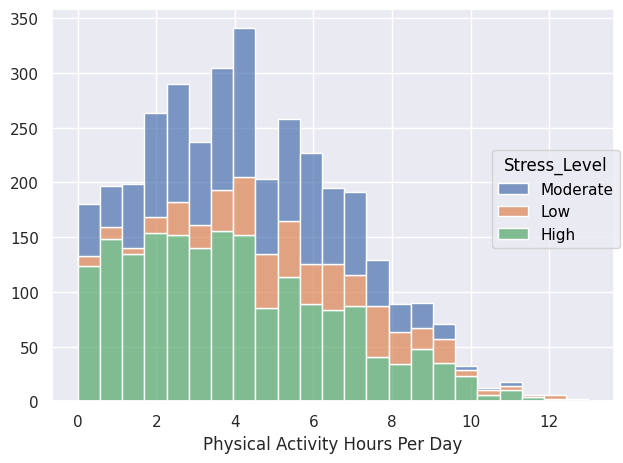

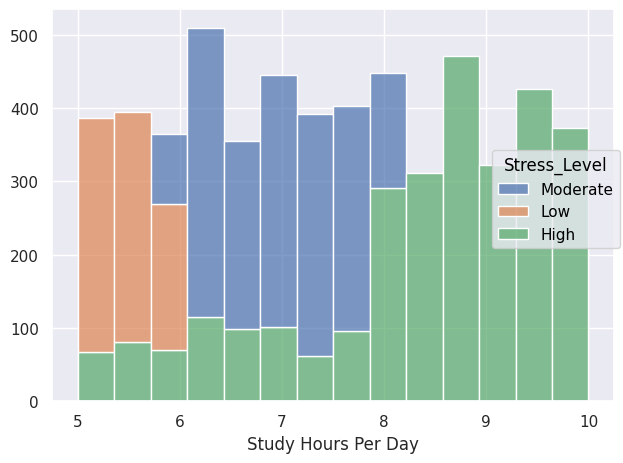

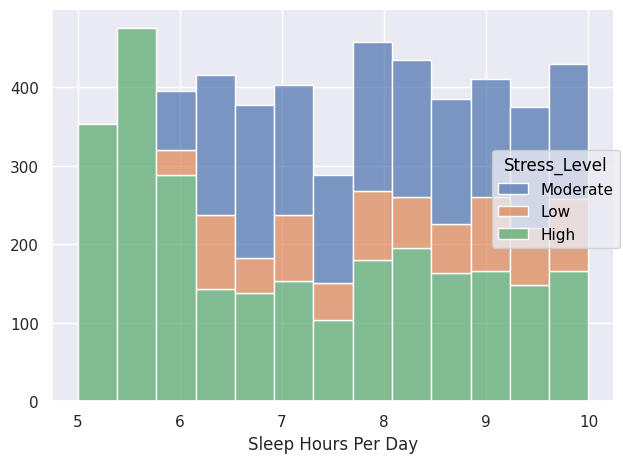

In [15]:
for variable in [PHYSICAL, STUDY, SLEEP]:
    (
        so.Plot(df, x=variable, color=STRESS)
        .add(so.Bars(), so.Hist(stat="frequency", common_norm=False), so.Stack())
        .label(x=humanize_column(variable))
        .show()
    )

# Perform hierarchical clustering on the dataset